## Predict Delivery Time Using Machine Learning

In [1]:
import numpy as np
import pandas as pd
import os
import time


import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
from mlxtend.plotting import scatterplotmatrix, heatmap

from sklearn import datasets
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer


print(pd.__version__)
pd.set_option('display.width', 160)  # default is 80
#pd.set_option('display.max_colwidth', 30)


pd.options.display.float_format = "{:,.2f}".format
#pd.options.display.float_format = "{:,.3g}".format
pd.set_option('max_columns', None)  # print all the columns
# pd.reset_option('max_columns') # go back to the default value
pd.set_option('display.max_columns', None)


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # default value is: 'last_expr'

# suppress scientific notion in ndarrays
np.set_printoptions(suppress=True,   formatter={
                    'float_kind': '{:0.2f}'.format})



1.0.5


## Data Description

The file `historical_data.csv` contains a subset of deliveries received at DoorDash in early 2015 in a subset of the cities. Each row in this file corresponds to one unique delivery. Each column corresponds to a feature as explained below. Note all money (dollar) values given in the data are in cents and all time duration values given are in seconds 
The target value to predict here is the total seconds value between `created_at` and `actual_delivery_time`. The fields included in the dataset are:

| Field | Description |
|-------------:|-----:|
|market_id|A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id|
|created_at|Timestamp in UTC when the order was submitted by the consumer to DoorDash|
|actual_delivery_time|Timestamp in UTC when the order was delivered to the consumer|
|store_id|An id representing the restaurant the order was submitted for|
|subtotal|Total value of the order submitted (in cents)|
|total_onshift_dashers|Number of available dashers who are within 10 miles of the store at the time of order creation |
|total_busy_dashers|Subset of above `total_onshift_dashers` who are currently working on an order|
|total_outstanding_orders|Number of orders within 10 miles of this order that are currently being processed|
|estimated_store_to_consumer_driving_duration|Estimated travel time between store and consumer (in seconds)|
|delivery_time (created from raw data)|Target variabel, total seconds value between `created_at` and `actual_delivery_time` (in seconds)|
`predict_data.csv`, which provides the new data that you must predict on using the model you build. This data was generated similar to the `historical_data.csv` and it contains the same columns as above, except for the following differences:
  * This file does not contain `actual_delivery_time`, since that is unknown at the time of prediction
  * This file contains `delivery_id` as additional field

## Load The Data 

Define the targe variable --  total delivery duration seconds, i.e., the time from
* Start: the time consumer submits the order (`created_at`) to
* End: when the order will be delivered to the consumer (`actual_delivery_time`)

Note that there are missing values in both features and target.

In [2]:
pwd

'C:\\jimzh_work\\Employment\\Job2022\\doordash'

In [3]:

date_cols = ['created_at',  'actual_delivery_time']
#df=pd.read_csv("file:/dbfs/FileStore/tables/historical_data.csv", parse_dates=date_cols)
df=pd.read_csv("historical_data.csv", parse_dates=date_cols)

date_cols = ['created_at']
#df2=pd.read_csv("file:/dbfs/FileStore/tables/predict_data.csv", parse_dates=date_cols)
df2=pd.read_csv("predict_data.csv", parse_dates=date_cols)

df['delivery_time'] = (df['actual_delivery_time'] - df['created_at']) / np.timedelta64(1, 's')
print(df.apply(lambda x: np.sum(pd.isna(x))))  #df.isnull().sum()
print(df.info())
df.describe().T


market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
subtotal                                            0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_store_to_consumer_driving_duration      526
delivery_time                                       7
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 10 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  float64       
 1   created_at                                    197428 non-null  datetime64[ns]
 2  

,count,mean,std,min,25%,50%,75%,max
market_id,"196,441.00",2.98,1.52,1.00,2.00,3.00,4.00,6.00
store_id,"197,428.00","3,530.51","2,053.50",1.00,"1,686.00","3,592.00","5,299.00","6,987.00"
subtotal,"197,428.00","2,682.33","1,823.09",0.00,"1,400.00","2,200.00","3,395.00","27,100.00"
total_onshift_dashers,"181,166.00",44.81,34.53,-4.00,17.00,37.00,65.00,171.00
total_busy_dashers,"181,166.00",41.74,32.15,-5.00,15.00,34.00,62.00,154.00
total_outstanding_orders,"181,166.00",58.05,52.66,-6.00,17.00,41.00,85.00,285.00
estimated_store_to_consumer_driving_duration,"196,902.00",545.36,219.35,0.00,382.00,544.00,702.00,"2,088.00"
delivery_time,"197,421.00","2,908.26","19,229.61",101.00,"2,104.00","2,660.00","3,381.00","8,516,859.00"


In [4]:
print(df2.apply(lambda x: np.sum(pd.isna(x))))
df.groupby(['market_id']).size()
df2.groupby(['market_id']).size()
print(df['market_id'].value_counts(normalize=True).sort_index(ascending=True))
df2['market_id'].value_counts(normalize=True).sort_index(ascending=True)

market_id                                        250
created_at                                         0
store_id                                           0
subtotal                                           0
total_onshift_dashers                           4633
total_busy_dashers                              4633
total_outstanding_orders                        4633
estimated_store_to_consumer_driving_duration      11
delivery_id                                        0
dtype: int64


market_id
1.00    38037
2.00    55058
3.00    23297
4.00    47599
5.00    18000
6.00    14450
dtype: int64

market_id
1.00     9819
2.00    15536
3.00     6233
4.00    13186
5.00     5564
6.00     4190
dtype: int64

1.00   0.19
2.00   0.28
3.00   0.12
4.00   0.24
5.00   0.09
6.00   0.07
Name: market_id, dtype: float64


1.00   0.18
2.00   0.28
3.00   0.11
4.00   0.24
5.00   0.10
6.00   0.08
Name: market_id, dtype: float64

In [5]:
print(df.describe().T)
print(df.apply(lambda x: np.sum(pd.isna(x))))  #df.isnull().sum()
df.query('delivery_time>1e5  or delivery_time.isnull()')

                                                  count     mean       std    min      25%      50%      75%          max
market_id                                    196,441.00     2.98      1.52   1.00     2.00     3.00     4.00         6.00
store_id                                     197,428.00 3,530.51  2,053.50   1.00 1,686.00 3,592.00 5,299.00     6,987.00
subtotal                                     197,428.00 2,682.33  1,823.09   0.00 1,400.00 2,200.00 3,395.00    27,100.00
total_onshift_dashers                        181,166.00    44.81     34.53  -4.00    17.00    37.00    65.00       171.00
total_busy_dashers                           181,166.00    41.74     32.15  -5.00    15.00    34.00    62.00       154.00
total_outstanding_orders                     181,166.00    58.05     52.66  -6.00    17.00    41.00    85.00       285.00
estimated_store_to_consumer_driving_duration 196,902.00   545.36    219.35   0.00   382.00   544.00   702.00     2,088.00
delivery_time           

TypeError: unhashable type: 'numpy.ndarray'

| delivery time in seconds | delivery time in minutes |delivery time in hours|
|-----:|-----:|-----:|
|  60 | 1 | .|
| 1800| 30 | 0.5|
| 3600| 60 | 1|

## Data Pre-Processing and Feature Engineering

As dsiscussed above, 'delivery_time' greater than 1e5 seconds (27.8 hours) or missing are considered as outliers, we will drop these records.

'market_id' with NA value with be filled with 0. In next step we will use OnehotEncoder to transform this varaible

Other variables ()'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'estimated_store_to_consumer_driving_duration') which have missing values will be filled with each individual mean value.

In [6]:
df = df[~pd.isna(df['delivery_time'])]
df = df[df['delivery_time'] <= 1e5]
df.rename(columns={'total_onshift_dashers': 'onshift_dashers', 'total_busy_dashers': 'busy_dashers',
          'total_outstanding_orders': 'orders', 'estimated_store_to_consumer_driving_duration': 'driving_duration'}
          , inplace=True)
df['market_id']=df['market_id'].fillna(0)
#df=df.dropna()
df = df.transform(lambda x: x.fillna(x.mean()))#df=df.fillna(df.mean())  

df['busy_dashers_pct']=df['busy_dashers'].div(df['onshift_dashers'])\
.replace(np.inf, 0).replace(-np.inf, 0).fillna(0)

df['subtotal_log'] = np.log10(df['subtotal']+0.1)
df['driving_duration_log'] = np.log10(df['driving_duration']+0.1)

df['delivery_time_log'] = np.log10(df['delivery_time'])
df['delivery_time_sqrt'] = np.sqrt(df['delivery_time'])
#df.reset_index(inplace=True)

df['created_at_local']=df['created_at'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
df['hour']=df['created_at_local'].dt.hour
#df['hour_abs']=abs(df['created_at_local'].dt.hour-14)
df['dayofmonth']=df['created_at_local'].dt.day
df['dayofweek']=df['created_at_local'].dt.dayofweek
df['evening']=np.where(df['hour']>=15, 1, 0)

print(df.info())
print(df.apply(lambda x: np.sum(pd.isna(x))))
df.describe().T


<class 'pandas.core.frame.DataFrame'>
Int64Index: 197418 entries, 0 to 197427
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype                     
---  ------                --------------   -----                     
 0   market_id             197418 non-null  float64                   
 1   created_at            197418 non-null  datetime64[ns]            
 2   actual_delivery_time  197418 non-null  datetime64[ns]            
 3   store_id              197418 non-null  int64                     
 4   subtotal              197418 non-null  int64                     
 5   onshift_dashers       197418 non-null  float64                   
 6   busy_dashers          197418 non-null  float64                   
 7   orders                197418 non-null  float64                   
 8   driving_duration      197418 non-null  float64                   
 9   delivery_time         197418 non-null  float64                   
 10  busy_dashers_pct      197418 non

,count,mean,std,min,25%,50%,75%,max
market_id,"197,418.00",2.96,1.54,0.00,2.00,3.00,4.00,6.00
store_id,"197,418.00","3,530.56","2,053.50",1.00,"1,686.00","3,592.00","5,299.00","6,987.00"
subtotal,"197,418.00","2,682.33","1,823.11",0.00,"1,400.00","2,200.00","3,395.00","27,100.00"
onshift_dashers,"197,418.00",44.81,33.07,-4.00,19.00,41.00,62.00,171.00
busy_dashers,"197,418.00",41.74,30.79,-5.00,17.00,39.00,59.00,154.00
orders,"197,418.00",58.05,50.44,-6.00,19.00,47.00,80.00,285.00
driving_duration,"197,418.00",545.36,219.06,0.00,383.00,544.00,702.00,"2,088.00"
delivery_time,"197,418.00","2,861.58","1,164.09",101.00,"2,104.00","2,660.00","3,381.00","57,032.00"
busy_dashers_pct,"197,418.00",0.93,0.41,-13.00,0.83,0.94,1.00,31.00
subtotal_log,"197,418.00",3.34,0.30,-1.00,3.15,3.34,3.53,4.43


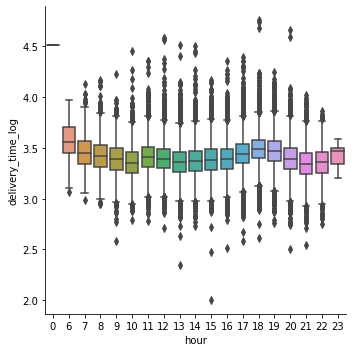

<AxesSubplot:xlabel='hour', ylabel='Count'>

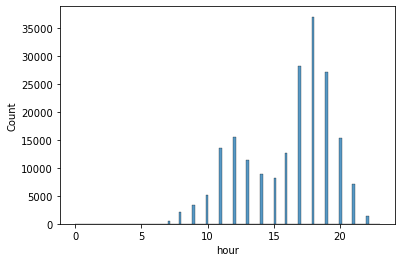

In [7]:

sn.catplot(x="hour", y="delivery_time_log", kind='box', data=df)
plt.show()
sn.histplot(x="hour",  data=df)

In [8]:
onehot = OneHotEncoder(drop='first', sparse=False)

marketid = df[['market_id']].values
onehot.fit(marketid)
marketid_encoded=pd.DataFrame(onehot.transform(marketid), columns=['market_id1','market_id2', 'market_id3','market_id4','market_id5','market_id6'])
marketid_encoded.head()
marketid_encoded.info()



OneHotEncoder(drop='first', sparse=False)

,market_id1,market_id2,market_id3,market_id4,market_id5,market_id6
0,1.00,0.00,0.00,0.00,0.00,0.00
1,0.00,1.00,0.00,0.00,0.00,0.00
2,0.00,0.00,1.00,0.00,0.00,0.00
3,0.00,0.00,1.00,0.00,0.00,0.00
4,0.00,0.00,1.00,0.00,0.00,0.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197418 entries, 0 to 197417
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   market_id1  197418 non-null  float64
 1   market_id2  197418 non-null  float64
 2   market_id3  197418 non-null  float64
 3   market_id4  197418 non-null  float64
 4   market_id5  197418 non-null  float64
 5   market_id6  197418 non-null  float64
dtypes: float64(6)
memory usage: 9.0 MB


In [9]:
#df=pd.DataFrame(np.column_stack([df,marketid_encoded]),    columns=df.columns.append(marketid_encoded.columns))
df=pd.concat([df.reset_index(), marketid_encoded], axis=1)
df.info()
df.head()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197418 entries, 0 to 197417
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype                     
---  ------                --------------   -----                     
 0   index                 197418 non-null  int64                     
 1   market_id             197418 non-null  float64                   
 2   created_at            197418 non-null  datetime64[ns]            
 3   actual_delivery_time  197418 non-null  datetime64[ns]            
 4   store_id              197418 non-null  int64                     
 5   subtotal              197418 non-null  int64                     
 6   onshift_dashers       197418 non-null  float64                   
 7   busy_dashers          197418 non-null  float64                   
 8   orders                197418 non-null  float64                   
 9   driving_duration      197418 non-null  float64                   
 10  delivery_time         197418 non

,index,market_id,created_at,actual_delivery_time,store_id,subtotal,onshift_dashers,busy_dashers,orders,driving_duration,delivery_time,busy_dashers_pct,subtotal_log,driving_duration_log,delivery_time_log,delivery_time_sqrt,created_at_local,hour,dayofmonth,dayofweek,evening,market_id1,market_id2,market_id3,market_id4,market_id5,market_id6
0,0,1.00,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,3441,33.00,14.00,21.00,861.00,"3,779.00",0.42,3.54,2.94,3.58,61.47,2015-02-06 14:24:17-08:00,14,6,4,0,1.00,0.00,0.00,0.00,0.00,0.00
1,1,2.00,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,1900,1.00,2.00,2.00,690.00,"4,024.00",2.00,3.28,2.84,3.60,63.44,2015-02-10 13:49:25-08:00,13,10,1,0,0.00,1.00,0.00,0.00,0.00,0.00
2,2,3.00,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,1900,1.00,0.00,0.00,690.00,"1,781.00",0.00,3.28,2.84,3.25,42.20,2015-01-22 12:39:28-08:00,12,22,3,0,0.00,0.00,1.00,0.00,0.00,0.00
3,3,3.00,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,6900,1.00,1.00,2.00,289.00,"3,075.00",1.00,3.84,2.46,3.49,55.45,2015-02-03 13:21:45-08:00,13,3,1,0,0.00,0.00,1.00,0.00,0.00,0.00
4,4,3.00,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,3900,6.00,6.00,9.00,650.00,"2,390.00",1.00,3.59,2.81,3.38,48.89,2015-02-14 18:40:36-08:00,18,14,5,1,0.00,0.00,1.00,0.00,0.00,0.00


,count,mean,std,min,25%,50%,75%,max
index,"197,418.00","98,714.00","56,991.87",0.00,"49,358.25","98,713.50","148,069.75","197,427.00"
market_id,"197,418.00",2.96,1.54,0.00,2.00,3.00,4.00,6.00
store_id,"197,418.00","3,530.56","2,053.50",1.00,"1,686.00","3,592.00","5,299.00","6,987.00"
subtotal,"197,418.00","2,682.33","1,823.11",0.00,"1,400.00","2,200.00","3,395.00","27,100.00"
onshift_dashers,"197,418.00",44.81,33.07,-4.00,19.00,41.00,62.00,171.00
busy_dashers,"197,418.00",41.74,30.79,-5.00,17.00,39.00,59.00,154.00
orders,"197,418.00",58.05,50.44,-6.00,19.00,47.00,80.00,285.00
driving_duration,"197,418.00",545.36,219.06,0.00,383.00,544.00,702.00,"2,088.00"
delivery_time,"197,418.00","2,861.58","1,164.09",101.00,"2,104.00","2,660.00","3,381.00","57,032.00"
busy_dashers_pct,"197,418.00",0.93,0.41,-13.00,0.83,0.94,1.00,31.00


### Correlation Matrix

The heatmap plots the correlation matrix of variables of interest. As we can see the correlation between featurs and target is not strong (smaller than 0.3). There is multicollinearity among the two dasher variables and 'orders'.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197418 entries, 0 to 197417
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype                     
---  ------                --------------   -----                     
 0   index                 197418 non-null  int64                     
 1   market_id             197418 non-null  float64                   
 2   created_at            197418 non-null  datetime64[ns]            
 3   actual_delivery_time  197418 non-null  datetime64[ns]            
 4   store_id              197418 non-null  int64                     
 5   subtotal              197418 non-null  int64                     
 6   onshift_dashers       197418 non-null  float64                   
 7   busy_dashers          197418 non-null  float64                   
 8   orders                197418 non-null  float64                   
 9   driving_duration      197418 non-null  float64                   
 10  delivery_time         197418 non

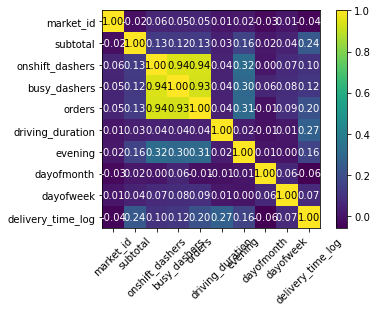

In [10]:
cols = ['market_id','subtotal', 'onshift_dashers', 'busy_dashers', 'orders',
        'driving_duration', 'evening', 'dayofmonth', 'dayofweek',  'delivery_time_log']
df.info()
cm = np.corrcoef(df[cols].values.T)
hm = heatmap(cm, row_names=cols, column_names=cols)

### Dealing with Multicollinearity

Based on the heatmap,  'onshift_dashers', 'busy_dashers' and 'orders' are strongly correlated. Here, we will combine the correlated columns into one to accommodate the slightest behavior of the individual columns. We do this by using the Principal Component Analysis (PCA) transformation technique.

In [11]:
#compress the columns 'onshift_dashers', 'busy_dashers', 'orders' into 1 column
pca = PCA(n_components=1)
#call the compressed column 'new'
df['new_dashers_orders'] = pca.fit_transform(df[['onshift_dashers', 'busy_dashers', 'orders']])

Out[43]: Out[43]:

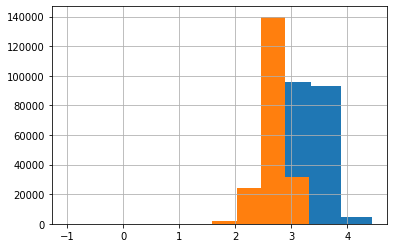

<AxesSubplot:>

In [0]:
df['subtotal_log'].hist()
df['driving_duration_log'].hist()

### Visualizing the important characteristics

A scatterplot matrix allows us to visualize the pair-wise correlations between the different features in this dataset in one place. Due to the large sample size, we can only select a small sample from the dataset to create the scatterplot. However, you can still quickly eyeball how the data is distributed. For example, we can see 'delivery_time' is right_skewed with outliers. The log transform 'delivery_time_log' is more normally distributed. The linear relationship between features and target variable 'delivery_time' is not very storng.

Out[44]:

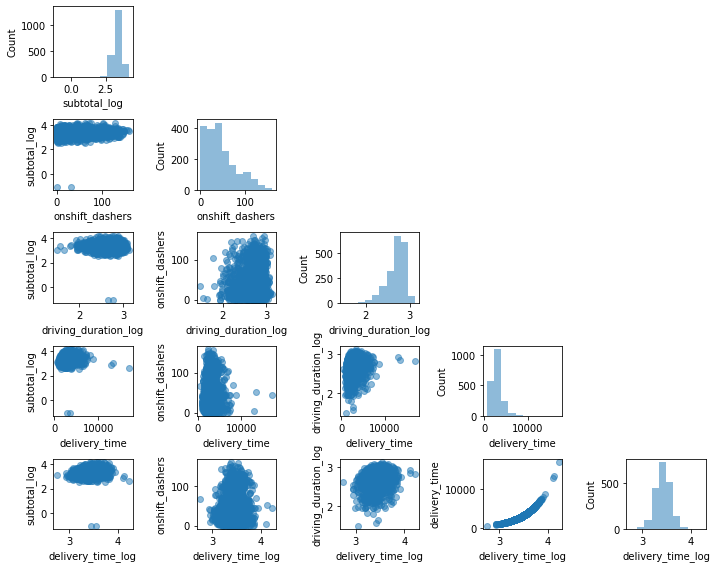

(<Figure size 720x576 with 25 Axes>,
 array([[<AxesSubplot:xlabel='subtotal_log', ylabel='Count'>,
 <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
 [<AxesSubplot:xlabel='onshift_dashers', ylabel='subtotal_log'>,
 <AxesSubplot:xlabel='onshift_dashers', ylabel='Count'>,
 <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
 [<AxesSubplot:xlabel='driving_duration_log', ylabel='subtotal_log'>,
 <AxesSubplot:xlabel='driving_duration_log', ylabel='onshift_dashers'>,
 <AxesSubplot:xlabel='driving_duration_log', ylabel='Count'>,
 <AxesSubplot:>, <AxesSubplot:>],
 [<AxesSubplot:xlabel='delivery_time', ylabel='subtotal_log'>,
 <AxesSubplot:xlabel='delivery_time', ylabel='onshift_dashers'>,
 <AxesSubplot:xlabel='delivery_time', ylabel='driving_duration_log'>,
 <AxesSubplot:xlabel='delivery_time', ylabel='Count'>,
 <AxesSubplot:>],
 [<AxesSubplot:xlabel='delivery_time_log', ylabel='subtotal_log'>,
 <AxesSubplot:xlabel='delivery_time_log', ylabel='onshift_dashers'>,
 <AxesSubplot:xlabel='delivery_time_log', ylabel='driving_duration_log'>,
 <AxesSubplot:xlabel='delivery_time_log', ylabel='delivery_time'>,
 <AxesSubplot:xlabel='delivery_time_log', ylabel='Count'>]],
 dtype=object))

In [0]:
cols=['subtotal_log', 'onshift_dashers', 'driving_duration_log', 'delivery_time', 'delivery_time_log']
dfsample=df.sample(frac=0.01)
scatterplotmatrix(dfsample[cols].values, figsize=(10, 8), names=cols, alpha=0.5)
plt.tight_layout()
#plt.savefig('images/10_03.png', dpi=300)
plt.show()

## Prepare Training and Test Data

Split dataset into separate training and test datasets, where we will use the former to fit the model and the latter to evaluate its performance. Also we do a feature scaling to standardize our features. Standardization will make it easier for us to check and compare the coefficeints in the model and in some way imdicates the variable importance. 

'dayofmonth' feature is not included in modeling because historical data covers from day 1 to day 30 whereas predict data only covers a couple of days in the month.

In [12]:

feature_cols = ['busy_dashers_pct', 'subtotal', 'orders', 'driving_duration', 'evening', 'dayofweek', 'market_id1','market_id2', 'market_id3','market_id4','market_id5','market_id6']

target_col='delivery_time_log'
X, y = df.loc[:, feature_cols], df.loc[:, target_col]

X=X.reset_index(drop=True)
y=y.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

#scaler = RobustScaler()
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

StandardScaler()

## Model Fitting and Performance measure

Order lateness/underprediction of delivery time is of particular concern as past experiments suggest that underestimating delivery time is roughly twice as costly as overestimating it. So in addition to the MAE and R2 measure, we also define two lateness measures:

* More than 5 minutes late: the percentage of predicted delivery time is more than 5 minutes late than actual delivery
* More than 10 minutes late: the percentage of predicted delivery time is more than 10 minutes late than actual delivery

The smaller the two lateness measures, the better our model performance.

In [13]:
def model_train_perf(model, title):

    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    #mae_train=mean_absolute_error(y_train, y_train_pred)
    #mae_test= mean_absolute_error(y_test, y_test_pred)

    mae_train = np.abs(np.power(10, y_train) -
                       np.power(10, y_train_pred)).mean()
    mae_test = np.abs(np.power(10, y_test) - np.power(10, y_test_pred)).mean()

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    late_5min_train = np.where(
        (np.power(10, y_train) - np.power(10, y_train_pred)) > 300, 1, 0).mean()
    late_5min_test = np.where(
        (np.power(10, y_test) - np.power(10, y_test_pred)) > 300, 1, 0).mean()

    late_10min_train = np.where(
        (np.power(10, y_train) - np.power(10, y_train_pred)) > 600, 1, 0).mean()
    late_10min_test = np.where(
        (np.power(10, y_test) - np.power(10, y_test_pred)) > 600, 1, 0).mean()

    plt.scatter(y_train_pred,  y_train_pred - y_train,
                c='steelblue', marker='o', edgecolor='white',
                label=f'Training,  $R^2={r2_train:.3f}$')
    plt.scatter(y_test_pred,  y_test_pred - y_test,
                c='limegreen', marker='s', edgecolor='white',
                label=f'Test,  $R^2={r2_test:.3f}$')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.axhline(y=0, xmin=0, xmax=1, color='black', lw=2)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    print('MAE train: %.3f, test: %.3f' % (mae_train, mae_test))
    print('R^2 train: %.3f, test: %.3f' % (r2_train, r2_test))

    print('More than 5 mins late: {:6.2%}, test: {:6.2%}' .format(
        late_5min_train,   late_5min_test))
    print('More than 10 mins late: {:6.2%}, test: {:6.2%}' .format(
        late_10min_train,   late_10min_test))
    return

### Baseline Model

LASSO acts a baseline model here as it forces the coefficients to zeroes and make the prediction at ybar. The MAE for test dataset is 805 seconds. The more than 5 mins lateness for test dataset is 37.77% and 10 mins lateness for test dataset is 27.94%.

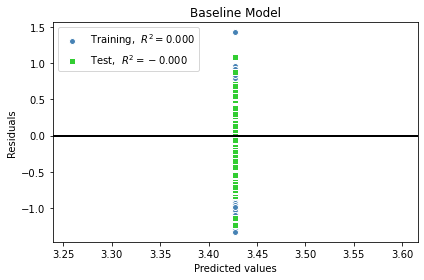

MAE train: 808.160, test: 804.806
R^2 train: 0.000, test: -0.000
More than 5 mins late: 37.42%, test: 37.77%
More than 10 mins late: 27.77%, test: 27.94%


In [14]:
lasso =Lasso(alpha=0.5)
model_train_perf(model=lasso, title='Baseline Model')

### Linear Regression Model

Linear Regression model performs better than the baseline model. The MAE for test dataset is 719 seconds The more than 5 mins lateness for test dataset is 34.52% and 10 mins lateness for test dataset is 24.67%. Linear Regression model reduces the MAE and lateness by 10%.

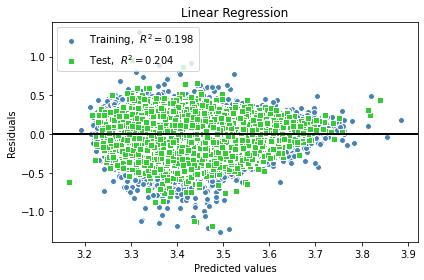

MAE train: 724.580, test: 719.467
R^2 train: 0.198, test: 0.204
More than 5 mins late: 34.74%, test: 34.52%
More than 10 mins late: 24.74%, test: 24.67%
Out[48]: {'fit_intercept': True,
 'normalize': False,
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'n_features_in_': 12,
 'coef_': array([0.01, 0.03, 0.04, 0.04, 0.01, 0.01, 0.02, -0.02, 0.01, -0.01, 0.01,
 -0.00]),
 '_residues': 3153.308039389867,
 'rank_': 12,
 'singular_': array([538.21, 465.41, 438.43, 427.82, 420.10, 416.48, 400.26, 393.25,
 383.60, 365.41, 259.22, 31.81]),
 'intercept_': 3.427342468733808}

In [0]:
lr = LinearRegression()
model_train_perf(model=lr, title='Linear Regression')
vars(lr)

### Decision Tree Model

Decision Tree Regression model is only slightly better than the baseline model. The MAE for test dataset is 733 seconds The more than 5 mins lateness for test dataset is 35.38% and 10 mins lateness for test dataset is 25.15%. Decision Tree model reduces the MAE and lateness by 9%.

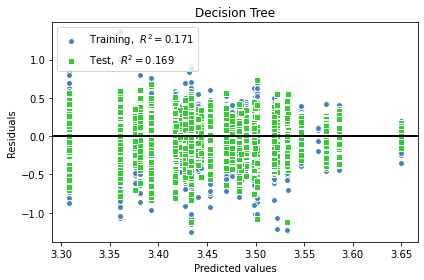

MAE train: 736.000, test: 733.061
R^2 train: 0.171, test: 0.169
More than 5 mins late: 35.42%, test: 35.38%
More than 10 mins late: 25.26%, test: 25.15%

In [0]:
dtree =DecisionTreeRegressor(max_depth=5)
model_train_perf(model=dtree, title='Decision Tree')

### Random Forest Model

Random Forest model performs better than the baseline model. The MAE for test dataset is 696 seconds The more than 5 mins lateness for test dataset is 34.49% and 10 mins lateness for test dataset is 24.06%. Random Forest model reduces the MAE by 12.5% and lateness by 10%.

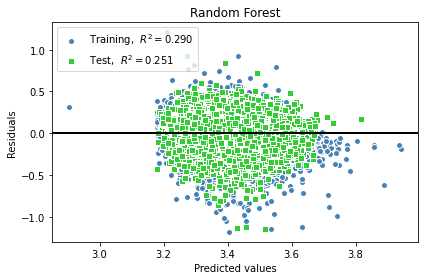

MAE train: 681.526, test: 696.940
R^2 train: 0.290, test: 0.251
More than 5 mins late: 34.25%, test: 34.49%
More than 10 mins late: 23.81%, test: 24.06%

In [0]:
rf =RandomForestRegressor(n_estimators=1000, 
                              max_depth=10,
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=-1)
model_train_perf(model=rf, title='Random Forest')

### Gradient Boosting Model

Gradient Boosting model performs as well as, if not better than Random Forest model. The MAE for test dataset is 696 seconds The more than 5 mins lateness for test dataset is 34.38% and 10 mins lateness for test dataset is 24.13%. Gradient Boosting model reduces the MAE by 12.5% and lateness by 10%.

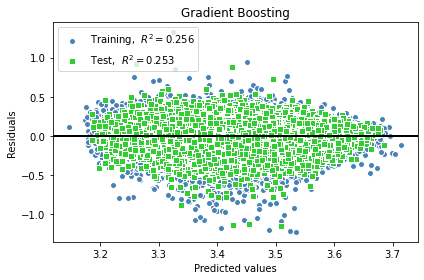

MAE train: 698.736, test: 696.570
R^2 train: 0.256, test: 0.253
More than 5 mins late: 34.47%, test: 34.38%
More than 10 mins late: 24.11%, test: 24.13%


In [16]:
gbr =GradientBoostingRegressor()
model_train_perf(model=gbr, title='Gradient Boosting')

### XGBoost Model

XGBoost is a more regularized form of Gradient Boosting. XGBoost uses advanced regularization (L1 & L2), which improves model generalization capabilities. XGBoost delivers high performance as compared to Gradient Boosting. Its training is very fast and can be parallelized across clusters.

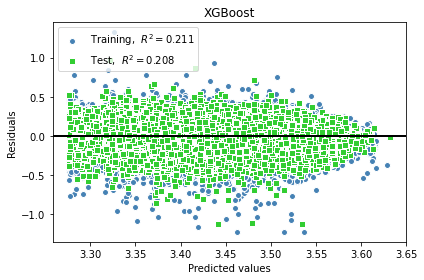

MAE train: 717.905, test: 715.700
R^2 train: 0.211, test: 0.208
More than 5 mins late: 34.94%, test: 35.08%
More than 10 mins late: 24.82%, test: 24.60%


In [15]:
import xgboost as xgb
from xgboost import XGBClassifier, XGBRFRegressor
xb = XGBRFRegressor()
model_train_perf(model=xb, title='XGBoost')

## Best Model and Feature Importance
We can see both Randmo Forest model and Gradient Boosting model performs very well and similarly. We will choose Gradient Boosting as our best model because its performance is more stabe across training and test datasets and less overfitting. 

The feature importance plot shows the 'estimated_store_to_consumer_driving_duration' is the most important driver, which is reasonable as it is prediction from other models for various stages of delivery process.

Out[62]: Out[62]: Out[62]:

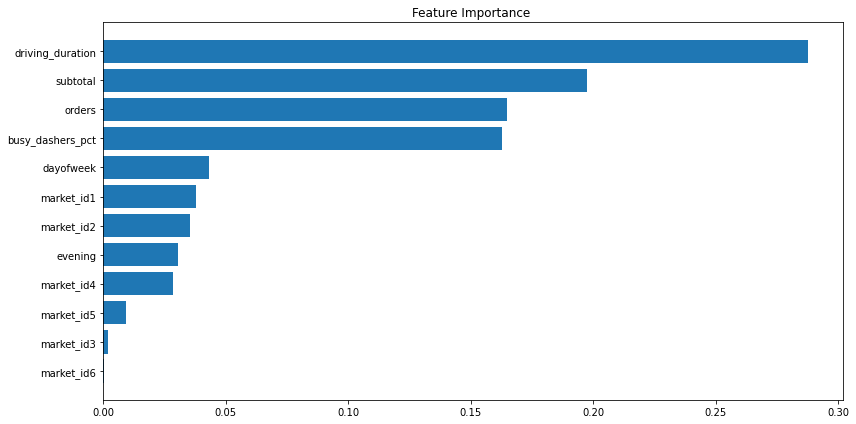

Text(0.5, 1.0, 'Feature Importance ')

In [0]:
from sklearn.inspection import permutation_importance
feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_cols)[sorted_idx])
plt.title("Feature Importance ")
fig.tight_layout()
plt.show()

## Load Predict Data

In [0]:
date_cols = ['created_at']
df2=pd.read_csv("file:/dbfs/FileStore/tables/predict_data.csv", parse_dates=date_cols)
print(df2.info())
print(df2.apply(lambda x: np.sum(pd.isna(x))))
df2.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54778 entries, 0 to 54777
Data columns (total 9 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 market_id 54528 non-null float64 
 1 created_at 54778 non-null datetime64[ns]
 2 store_id 54778 non-null int64 
 3 subtotal 54778 non-null int64 
 4 total_onshift_dashers 50145 non-null float64 
 5 total_busy_dashers 50145 non-null float64 
 6 total_outstanding_orders 50145 non-null float64 
 7 estimated_store_to_consumer_driving_duration 54767 non-null float64 
 8 delivery_id 54778 non-null int64 
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 3.8 MB
None
market_id 250
created_at 0
store_id 0
subtotal 0
total_onshift_dashers 4633
total_busy_dashers 4633
total_outstanding_orders 4633
estimated_store_to_consumer_driving_duration 11
delivery_id 0
dtype: int64
Out[28]:

,count,mean,std,min,25%,50%,75%,max
market_id,"54,528.00",3.03,1.53,1.00,2.00,3.00,4.00,6.00
store_id,"54,778.00","3,489.64","2,050.22",2.00,"1,661.00","3,518.00","5,247.00","6,986.00"
subtotal,"54,778.00","2,715.76","1,897.92",0.00,"1,420.00","2,220.00","3,415.00","29,925.00"
total_onshift_dashers,"50,145.00",49.08,37.59,-1.00,19.00,41.00,71.00,175.00
total_busy_dashers,"50,145.00",43.52,34.05,-4.00,16.00,36.00,63.00,169.00
total_outstanding_orders,"50,145.00",62.57,56.38,-9.00,19.00,45.00,91.00,292.00
estimated_store_to_consumer_driving_duration,"54,767.00",547.77,220.46,0.00,385.00,544.00,703.00,"1,550.00"
delivery_id,"54,778.00","126,118.10","72,683.61",20.00,"62,938.50","126,194.00","188,916.00","252,031.00"


## Check Consistency of Historical Data and Predict Data

Out[29]: Out[29]:

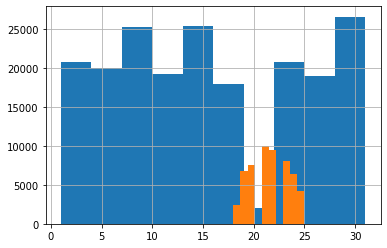

<AxesSubplot:>

In [0]:
df['created_at'].dt.day.hist()
df2['created_at'].dt.day.hist()

Out[30]: Out[30]:

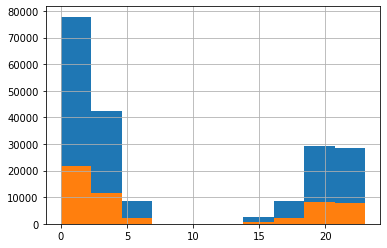

<AxesSubplot:>

In [0]:
#UTC 19pm-4am 11am-20pm
df['created_at'].dt.hour.hist()
df2['created_at'].dt.hour.hist()

Out[31]: Out[31]:

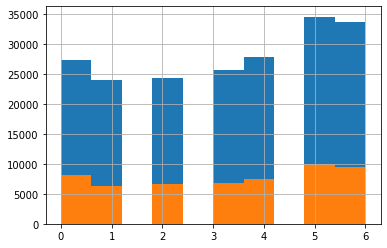

<AxesSubplot:>

In [0]:
df['created_at'].dt.dayofweek.hist()
df2['created_at'].dt.dayofweek.hist()

##Score Predict Data Based on Best Model

In [0]:

date_cols = ['created_at']
df2=pd.read_csv("file:/dbfs/FileStore/tables/predict_data.csv", parse_dates=date_cols)

df2.rename(columns={'total_onshift_dashers': 'onshift_dashers', 'total_busy_dashers': 'busy_dashers',
          'total_outstanding_orders': 'orders', 'estimated_store_to_consumer_driving_duration': 'driving_duration'}, inplace=True)
df2['market_id']=df2['market_id'].fillna(0)
df2 = df2.transform(lambda x: x.fillna(x.mean()))

df2['busy_dashers_pct']=df2['busy_dashers'].div(df2['onshift_dashers']).replace(np.inf, 0).replace(-np.inf, 0).fillna(0)

df2['subtotal_log'] = np.log10(df2['subtotal']+0.1)
df2['driving_duration_log'] = np.log10(df2['driving_duration']+0.1)

df2['created_at_local']=df2['created_at'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
df2['hour']=df2['created_at_local'].dt.hour
#df2['hour_abs']=abs(df2['created_at_local'].dt.hour-14)
df2['dayofmonth']=df2['created_at_local'].dt.dayofweek
df2['dayofweek']=df2['created_at_local'].dt.day
df2['evening']=np.where(df2['hour']>=15, 1, 0)

print(df2.info())
print(df2.apply(lambda x: np.sum(pd.isna(x))))
df2.describe().T

marketid = df2[['market_id']].values
onehot.fit(marketid)
marketid_encoded=pd.DataFrame(onehot.transform(marketid), columns=['market_id1','market_id2', 'market_id3','market_id4','market_id5','market_id6'])
marketid_encoded.head()
marketid_encoded.info()

df2=pd.concat([df2.reset_index(), marketid_encoded], axis=1)

#pca = PCA(n_components=1)
#call the compressed column 'new'
df2['new_dashers_orders'] = pca.fit_transform(df2[['onshift_dashers', 'busy_dashers', 'orders']])


X2 = df2.loc[:, feature_cols]

X2 = scaler.transform(X2)

df2['predicted_duration'] = np.power(10, gbr.predict(X2))
df2['predicted_duration2']= np.power(10, rf.predict(X2))

df2.info()
df2.head()
df2.describe().T

df2[['delivery_id', 'predicted_duration']].to_csv("/dbfs/FileStore/tables/data_to_predict.csv", index=False)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54778 entries, 0 to 54777
Data columns (total 17 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 market_id 54778 non-null float64 
 1 created_at 54778 non-null datetime64[ns] 
 2 store_id 54778 non-null int64 
 3 subtotal 54778 non-null int64 
 4 onshift_dashers 54778 non-null float64 
 5 busy_dashers 54778 non-null float64 
 6 orders 54778 non-null float64 
 7 driving_duration 54778 non-null float64 
 8 delivery_id 54778 non-null int64 
 9 busy_dashers_pct 54778 non-null float64 
 10 subtotal_log 54778 non-null float64 
 11 driving_duration_log 54778 non-null float64 
 12 created_at_local 54778 non-null datetime64[ns, US/Pacific]
 13 hour 54778 non-null int64 
 14 dayofmonth 54778 non-null int64 
 15 dayofweek 54778 non-null int64 
 16 evening 54778 non-null int64 
dtypes: datetime64[ns, US/Pacific](1), datetime64[ns](1), float64(8), int64(7)
memory usage: 7.1 MB
None
market_id 0
created_at 0
store_id 0
subtotal 0
onshift_dashers 0
busy_dashers 0
orders 0
driving_duration 0
delivery_id 0
busy_dashers_pct 0
subtotal_log 0
driving_duration_log 0
created_at_local 0
hour 0
dayofmonth 0
dayofweek 0
evening 0
dtype: int64
Out[53]: Out[53]: Out[53]: <class 'pandas.core.frame.DataFrame'>
RangeIndex: 54778 entries, 0 to 54777
Data columns (total 6 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 market_id1 54778 non-null float64
 1 market_id2 54778 non-null float64
 2 market_id3 54778 non-null float64
 3 market_id4 54778 non-null float64
 4 market_id5 54778 non-null float64
 5 market_id6 54778 non-null float64
dtypes: float64(6)
memory usage: 2.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54778 entries, 0 to 54777
Data columns (total 27 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 index 54778 non-null int64 
 1 market_id 54778 non-null float64 
 2 created_at 54778 non-null datetime64[ns] 
 3 store_id 54778 non-null int64 
 4 subtotal 54778 non-null int64 
 5 onshift_dashers 54778 non-null float64 
 6 busy_dashers 54778 non-null float64 
 7 orders 54778 non-null float64 
 8 driving_duration 54778 non-null float64 
 9 delivery_id 54778 non-null int64 
 10 busy_dashers_pct 54778 non-null float64 
 11 subtotal_log 54778 non-null float64 
 12 driving_duration_log 54778 non-null float64 
 13 created_at_local 54778 non-null datetime64[ns, US/Pacific]
 14 hour 54778 non-null int64 
 15 dayofmonth 54778 non-null int64 
 16 dayofweek 54778 non-null int64 
 17 evening 54778 non-null int64 
 18 market_id1 54778 non-null float64 
 19 market_id2 54778 non-null float64 
 20 market_id3 54778 non-null float64 
 21 market_id4 54778 non-null float64 
 22 market_id5 54778 non-null float64 
 23 market_id6 54778 non-null float64 
 24 new_dashers_orders 54778 non-null float64 
 25 predicted_duration 54778 non-null float64 
 26 predicted_duration2 54778 non-null float64 
dtypes: datetime64[ns, US/Pacific](1), datetime64[ns](1), float64(17), int64(8)
memory usage: 11.3 MB
Out[53]: Out[53]:

,count,mean,std,min,25%,50%,75%,max
index,"54,778.00","27,388.50","15,813.19",0.00,"13,694.25","27,388.50","41,082.75","54,777.00"
market_id,"54,778.00",3.02,1.54,0.00,2.00,3.00,4.00,6.00
store_id,"54,778.00","3,489.64","2,050.22",2.00,"1,661.00","3,518.00","5,247.00","6,986.00"
subtotal,"54,778.00","2,715.76","1,897.92",0.00,"1,420.00","2,220.00","3,415.00","29,925.00"
onshift_dashers,"54,778.00",49.08,35.97,-1.00,20.00,46.00,67.00,175.00
busy_dashers,"54,778.00",43.52,32.58,-4.00,18.00,41.00,60.00,169.00
orders,"54,778.00",62.57,53.94,-9.00,21.00,53.00,85.00,292.00
driving_duration,"54,778.00",547.77,220.44,0.00,385.00,544.00,703.00,"1,550.00"
delivery_id,"54,778.00","126,118.10","72,683.61",20.00,"62,938.50","126,194.00","188,916.00","252,031.00"
busy_dashers_pct,"54,778.00",0.87,0.20,-4.00,0.81,0.93,1.00,8.00


In [133]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import RidgeCV, Ridge
X, y = load_diabetes(return_X_y=True)
clf = RidgeCV(alphas=(1e-3, 1e-2, 1e-1, 1), cv=10).fit(X, y)
clf.best_score_
clf.score(X, y)

0.4633240541517593

0.5125629767961003

In [138]:
from sklearn.model_selection import GridSearchCV
gcv=GridSearchCV(Ridge(),  param_grid={'alpha': (1e-3, 1e-2, 1e-1, 1)}, cv=10).fit(X, y)
gcv.score(X, y)
gcv.best_params_
gcv.best_estimator_

0.5125629767961003

{'alpha': 0.1}

Ridge(alpha=0.1)

In [74]:
a=(1,2)
b=(1,2)
a+=b
a 
b

(1, 2, 1, 2)

(1, 2)

In [96]:
a={1,2,3,4}
b={1,2}
c={2}
a-= b - c 

a 
b

{2, 3, 4}

{1, 2}

In [98]:
print(round(100.000056, 0))

100.0


In [104]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate, cross_val_score, learning_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
diabetes = datasets.load_diabetes()
X = diabetes.data[:150]
y = diabetes.target[:150]
lasso = linear_model.Lasso()
cv_results = cross_validate(lasso, X, y, cv=3)
sorted(cv_results.keys())
cv_results['test_score']

['fit_time', 'score_time', 'test_score']

array([0.33, 0.08, 0.04])

In [103]:
cross_val_score(lasso, X, y, cv=3)

array([0.33, 0.08, 0.04])

In [115]:
train_sizes, train_scores,test_scores=learning_curve(estimator=lasso, X=X, y=y, train_sizes=(0.25, 0.5, 0.75,1), cv=3)
train_sizes
train_scores
test_scores

array([ 25,  50,  75, 100])

array([[0.13, 0.51, 0.51],
       [0.01, 0.41, 0.41],
       [0.15, 0.35, 0.29],
       [0.28, 0.39, 0.23]])

array([[0.04, 0.13, 0.13],
       [-0.04, 0.16, 0.24],
       [0.21, 0.07, 0.09],
       [0.33, 0.08, 0.04]])

In [111]:
X.shape

(150, 10)